# Surprise Utility: Design Matrix

Author: Brenden Eum (2022)

This script will simualte a fake dataset of trial variables:

- onset time
- trial type
- duration
- amplitude

It will then convolve these variables. Checking the correlation between convolved variables helps us to test if we will run into collinearity issues when analyzing the real data.

In [85]:
# Start fresh.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from nilearn.plotting import plot_event, plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
np.random.seed(1337)

# Set directories.
codedir = os.getcwd()
figdir = codedir + "\\..\\figures\\"

# Experiment design.

numBlockTrials = 32 # number of trials per block
numNoDelay = 8 # number of trials with no delay
numDelay = 24 # number of trials with delay

Write a function that generates an array of event durations. Later, we will shuffle these at the start of every block to generate trial durations. This keeps block duration constant.


In [41]:
def get_durations():    
    
    # Initial fixation cross.
    
    init_fix_dur = np.random.randint(
        low = 1,
        high = 9,
        size = numBlockTrials
    )

    # Pie.
    
    pie_dur = np.repeat(1, numBlockTrials)

    # Wait fixation cross.
    
    wait_dur = np.random.randint(
        low = 3,
        high = 6,
        size = numBlockTrials
    )
    
    # Outcome.
    
    out_dur = np.repeat(1, numBlockTrials)

    # Delay screen duration. 5 seconds, not including the 1 second for the .
    
    delay_dur = np.repeat(5, numBlockTrials)

    # Reward.
    
    reward_dur = np.repeat(4, numBlockTrials)

    # Swallow.
    
    swallow_dur = np.repeat(2, numBlockTrials)

    # Combine all of this into one list.
    
    df = {
        'init_fix_dur' : init_fix_dur,
        'pie_dur' : pie_dur,
        'wait_dur' : wait_dur,
        'out_dur' : out_dur,
        'delay_dur' : delay_dur,
        'reward_dur' : reward_dur,
        'swallow_dur' : swallow_dur
    }
    durations = pd.DataFrame(data=df)
    
    # Return.
    
    return durations

Make a dataframe that captures the trial structure. Each observation should be one trial. 128 trials split into 4 blocks, 32 trials per block, 8 no delay and 24 delay. 

In [42]:
# Delay or no delay condition.

delay = [*np.repeat(0,numNoDelay), *np.repeat(1,numDelay)]

# Probabilities.

probs = [
    *np.repeat(0,numNoDelay/2), 
    *np.repeat(1,numNoDelay/2), 
    *np.repeat(0,numDelay/6), 
    *np.repeat(1,numDelay/6), 
    *np.repeat(.33,numDelay/3), 
    *np.repeat(.67,numDelay/3)
]

# Combine delay and probabilties so you have a template for trials in a block. We can randomize the order of this df later.

dp = {'delay':delay, 'probs':probs}
block = pd.DataFrame(data=dp)

# Expand conditions across whole experiment.

block1 = block.sample(frac=1)
block2 = block.sample(frac=1)
block3 = block.sample(frac=1)
block4 = block.sample(frac=1)
frames = [block1, block2, block3, block4]
trial_struct = pd.concat(frames)

# Add subject number, trial, and block.

trial_struct['subject'] = 1
trial_struct['trial'] = np.arange(1,numBlockTrials*4+1,1)
trial_struct['block'] = np.array([
    *np.repeat(1,numBlockTrials), 
    *np.repeat(2,numBlockTrials), 
    *np.repeat(3,numBlockTrials), 
    *np.repeat(4,numBlockTrials)
])

# Outcome.

trial_struct['outcome'] = np.random.binomial(1, trial_struct['probs'])

# Display the dataframe.

trial_struct.reset_index(inplace=True, drop=True)
print(trial_struct)

     delay  probs  subject  trial  block  outcome
0        1   0.33        1      1      1        1
1        1   0.33        1      2      1        0
2        1   1.00        1      3      1        1
3        0   1.00        1      4      1        1
4        0   0.00        1      5      1        0
..     ...    ...      ...    ...    ...      ...
123      1   0.33        1    124      4        1
124      1   0.33        1    125      4        1
125      1   0.67        1    126      4        1
126      1   0.00        1    127      4        0
127      0   1.00        1    128      4        1

[128 rows x 6 columns]


Write a function that generates fMRI data depending on the type of trial. Inputs:

- a row from the trial structure dataframe
- a dictionary of event durations

In [43]:
def gen_fmri_data(trial_struct_row, durations_row, onset):
    
    # Placeholder.
    
    df = {
        'onset' : [0],
        'trial_type' : [''],
        'duration' : [0],
        'amplitude' : [0]
    }
    data = pd.DataFrame(data=df)
    
    r = -1
    
    # Initial fixation cross.
    
    r += 1
    onset = onset + durations_row['swallow_dur']  # Onset is the start time of swallow screen last trial rn. Update it.
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'init_fix_event'
    data.loc[r,'duration'] = durations_row['init_fix_dur']
    data.loc[r,'amplitude'] = 1
    
    # Pie. Centered.
    
    r += 1
    onset = onset + durations_row['init_fix_dur']
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'pie_event'
    data.loc[r,'duration'] = durations_row['pie_dur']
    data.loc[r,'amplitude'] = 1
    
    r += 1
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'pie_par'
    data.loc[r,'duration'] = durations_row['pie_dur']
    if trial_struct_row['probs'] == 0.00:
        data.loc[r,'amplitude'] = -(1/2)
    if trial_struct_row['probs'] == 0.33:
        data.loc[r,'amplitude'] = -(1/6)
    if trial_struct_row['probs'] == 0.67:
        data.loc[r,'amplitude'] = 1/6
    if trial_struct_row['probs'] == 1.00:
        data.loc[r,'amplitude'] = 1/2
    
    # Waiting fixation cross.
    
    r += 1
    onset = onset + durations_row['pie_dur']
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'wait_fix_event'
    data.loc[r,'duration'] = durations_row['wait_dur']
    data.loc[r,'amplitude'] = 1
    
    # Add outcome and delay screens if this trial includes delay condition.
    
    if trial_struct_row['delay'] == 1:
        
        # Outcome. Centered.
        r += 1
        onset = onset + durations_row['wait_dur']
        data.loc[r,'onset'] = onset
        data.loc[r,'trial_type'] = 'out_event'
        data.loc[r,'duration'] = durations_row['out_dur']
        data.loc[r,'amplitude'] = 1
        
        r += 1
        data.loc[r,'onset'] = onset
        data.loc[r,'trial_type'] = 'out_par'
        data.loc[r,'duration'] = durations_row['out_dur']
        if trial_struct_row['outcome'] == 1:
            data.loc[r,'amplitude'] = 1
        if trial_struct_row['outcome'] == 0:
            data.loc[r,'amplitude'] = -1
            
        # Delay.
        r += 1
        onset = onset + durations_row['out_dur']
        data.loc[r,'onset'] = onset
        data.loc[r,'trial_type'] = 'delay_event'
        data.loc[r,'duration'] = durations_row['delay_dur']
        data.loc[r,'amplitude'] = 1
        
    # Reward. Centered.
    
    r += 1
    onset = onset + data.loc[r-1, 'duration']
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'reward_event'
    data.loc[r,'duration'] = durations_row['reward_dur']
    data.loc[r,'amplitude'] = 1

    r += 1
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'reward_par'
    data.loc[r,'duration'] = durations_row['reward_dur']
    if trial_struct_row['outcome'] == 1:
        data.loc[r,'amplitude'] = 1
    if trial_struct_row['outcome'] == 0:
        data.loc[r,'amplitude'] = -1
        
    # Swallow.
    
    r += 1
    onset = onset + durations_row['reward_dur']
    data.loc[r,'onset'] = onset
    data.loc[r,'trial_type'] = 'swallow_event'
    data.loc[r,'duration'] = durations_row['swallow_dur']
    data.loc[r,'amplitude'] = 1
   
    return data

Generate the events dataframe.

    onset      trial_type  duration  amplitude
0     0.0  init_fix_event       8.0   1.000000
1     8.0       pie_event       1.0   1.000000
2     8.0         pie_par       1.0  -0.166667
3     9.0  wait_fix_event       5.0   1.000000
4    14.0       out_event       1.0   1.000000
..    ...             ...       ...        ...
5   621.0         out_par       1.0  -1.000000
6   622.0     delay_event       5.0   1.000000
7   627.0    reward_event       4.0   1.000000
8   627.0      reward_par       4.0  -1.000000
9   631.0   swallow_event       2.0   1.000000

[296 rows x 4 columns]


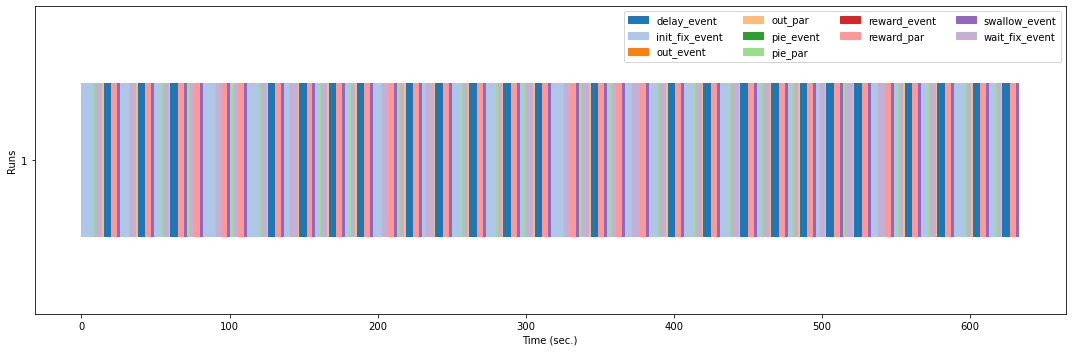

In [44]:
# Set seed.

np.random.seed(1337)

# Block 1.

durations = get_durations()

# First trial.

onset = -durations['swallow_dur'][0] # Onset is the start time of swallow screen last trial. We want to start at 0 though.
events = gen_fmri_data(trial_struct.iloc[0], durations.iloc[0], onset)
onset = events['onset'].iloc[-1]

# Rest of the block.

for i in range(1, numBlockTrials):
    
    newdata = gen_fmri_data(trial_struct.iloc[i], durations.iloc[i], onset)
    onset = newdata['onset'].iloc[-1]
    events = pd.concat([events, newdata])

# # Block 2.

# durations = get_durations()

# for i in range(0, numBlockTrials):
    
#     newdata = gen_fmri_data(trial_struct.iloc[i], durations.iloc[i], onset)
#     onset = newdata['onset'].iloc[-1]
#     events = pd.concat([events, newdata])

# # Block 3.

# durations = get_durations()

# for i in range(0, numBlockTrials):
    
#     newdata = gen_fmri_data(trial_struct.iloc[i], durations.iloc[i], onset)
#     onset = newdata['onset'].iloc[-1]
#     events = pd.concat([events, newdata])

# # Block 4.

# durations = get_durations()

# for i in range(0, numBlockTrials):
    
#     newdata = gen_fmri_data(trial_struct.iloc[i], durations.iloc[i], onset)
#     onset = newdata['onset'].iloc[-1]
#     events = pd.concat([events, newdata])

print(events)
plot_event(events, figsize=(15, 5))
plt.show()

Event-related design matrix.

In [104]:
# Image acquisition.

tr = 1.0 # repetition time (scanning frequency time)
n_scans = int(events['onset'].iloc[-1] + events['duration'].iloc[-1]) # how many total scans per block (block time / 1s tr)
frame_times = np.arange(n_scans) * tr # frame times

# hrf

hrf_model = 'glover'

# Next, we simulate 6 motion parameters jointly observed with fMRI acquisitions

motion = np.cumsum(np.random.randn(n_scans, 6), 0)

# The 6 parameters correspond to three translations and three
# rotations describing rigid body motion

add_reg_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

# Make the design matrix.

X1 = make_first_level_design_matrix(
    frame_times, 
    events, 
    drift_model = 'polynomial', 
    drift_order = 3,
    add_regs = motion, 
    add_reg_names = add_reg_names, 
    hrf_model = hrf_model
)

X1

C:\Users\Brend\AppData\Roaming\Python\Python39\site-packages\nilearn\glm\first_level\experimental_paradigm.py:89: UserWarning: Unexpected column `amplitude` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
C:\Users\Brend\AppData\Roaming\Python\Python39\site-packages\nilearn\_utils\glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


,delay_event,init_fix_event,out_event,out_par,pie_event,pie_par,reward_event,reward_par,swallow_event,wait_fix_event,tx,ty,tz,rx,ry,rz,drift_1,drift_2,drift_3,constant
0.0,-9.526063e-14,-9.582674e-14,1.612591e-14,-9.597528e-14,-9.076449e-14,1.631238e-14,3.394375e-14,-1.374270e-13,-8.291725e-14,-9.373448e-14,-1.405684,0.985289,-0.517297,-0.950964,0.448243,-1.939930,-0.500000,0.166403,-0.049763,1.0
1.0,-9.622852e-14,4.352714e-04,2.041674e-14,-1.009036e-13,-9.087488e-14,1.707299e-14,3.978107e-14,-1.470454e-13,-8.332993e-14,-9.345698e-14,-1.303496,1.331084,-1.623470,-2.114863,0.047579,-2.976850,-0.498418,0.164823,-0.048818,1.0
2.0,-9.465682e-14,1.788380e-02,-3.616322e-13,3.018558e-13,-2.353584e-14,-6.033291e-14,-1.839467e-13,9.286798e-14,-8.830903e-14,-9.542672e-14,-0.443331,1.202314,-2.024472,-1.156897,1.076060,-3.867040,-0.496835,0.163248,-0.047881,1.0
3.0,-8.595447e-14,1.079369e-01,1.980810e-14,-8.986689e-14,-8.161782e-14,1.647483e-14,2.859264e-14,-1.322947e-13,-7.464610e-14,-7.951249e-14,-0.529542,0.423674,-3.519079,-1.479994,0.613405,-4.557370,-0.495253,0.161679,-0.046951,1.0
4.0,-6.660599e-14,3.032148e-01,1.639278e-13,-2.186939e-13,1.176974e-13,-1.729293e-13,-3.068010e-13,2.265826e-13,-6.113121e-14,-5.659168e-14,-1.603415,1.113467,-3.422396,-2.071022,0.823079,-4.205558,-0.493671,0.160114,-0.046028,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628.0,8.335742e-01,-1.771302e-01,2.197734e-01,2.197734e-01,-2.351391e-02,-2.351391e-02,-3.424428e-02,-3.424428e-02,-5.142116e-02,2.329620e-01,11.965334,27.589075,-25.102637,-2.377794,-21.093283,-16.366731,0.493671,0.160114,0.046028,1.0
629.0,1.038157e+00,-1.636352e-01,1.457193e-01,1.457193e-01,-4.330381e-02,-4.330381e-02,-4.178185e-03,-4.178185e-03,-3.648811e-02,6.372885e-02,11.529704,26.993702,-24.615582,-0.949854,-21.329296,-15.698993,0.495253,0.161679,0.046951,1.0
630.0,1.095129e+00,-1.361140e-01,7.260361e-02,7.260361e-02,-4.913357e-02,-4.913357e-02,9.436539e-02,9.436539e-02,-2.467152e-02,-5.217857e-02,11.402956,25.769699,-24.374031,-0.219984,-21.123151,-16.569311,0.496835,0.163248,0.047881,1.0
631.0,9.731903e-01,-1.048950e-01,1.463915e-02,1.463915e-02,-4.609471e-02,-4.609471e-02,2.951142e-01,2.951142e-01,-1.600257e-02,-1.159513e-01,11.385644,25.814642,-25.537060,0.266572,-22.367087,-15.083311,0.498418,0.164823,0.048818,1.0


Plot design matrix.

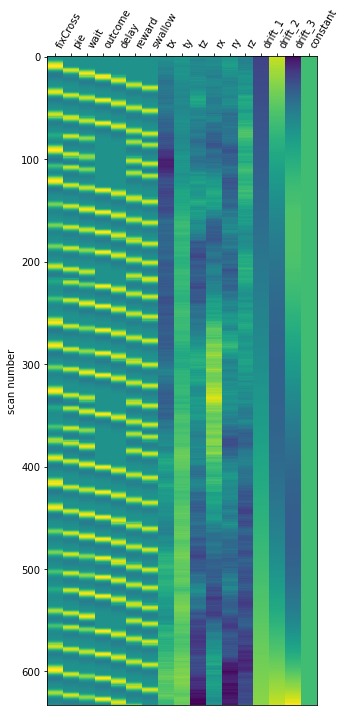

In [108]:
X_design = X1[[
    'init_fix_event',
    'pie_event',
    'wait_fix_event',
    'out_event',
    'delay_event',
    'reward_event',
    'swallow_event',
    'tx',
    'ty',
    'tz',
    'rx',
    'ry',
    'rz',
    'drift_1',
    'drift_2',
    'drift_3',
    'constant'
]]
X_design = X_design.rename(columns={
    'delay_event' : 'delay',
    'init_fix_event' : 'fixCross',
    'out_event' : 'outcome',
    'pie_event' : 'pie',
    'reward_event' : 'reward',
    'swallow_event' : 'swallow', 
    'wait_fix_event' : 'wait'
})

fig = plot_design_matrix(X_design)

fig = fig.get_figure()

fig.savefig(figdir + 'design_matrix.pdf', bbox_inches='tight')

Get the correlations between the independent variables.

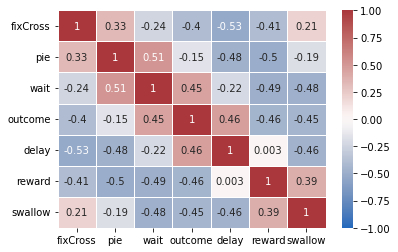

In [109]:
X_corr = X1[['init_fix_event','pie_event','wait_fix_event','out_event','delay_event','reward_event','swallow_event']]
X_corr = X_corr.rename(columns={
    'delay_event' : 'delay',
    'init_fix_event' : 'fixCross',
    'out_event' : 'outcome',
    'pie_event' : 'pie',
    'reward_event' : 'reward',
    'swallow_event' : 'swallow', 
    'wait_fix_event' : 'wait'
})

corr_matrix = X_corr.corr()
corr_plot = sn.heatmap(
    corr_matrix, 
    annot=True, 
    linewidth=.5, 
    cmap='vlag',
    vmax=1,
    vmin=-1
)

fig = corr_plot.get_figure()
fig.savefig(figdir + 'event_correlations.pdf', bbox_inches='tight')